Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [261]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [262]:
def plot_2d_clf_problem(X, y, h=None, ax=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        if (ax is not None):
            ax.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        else:
            plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    if (ax is not None):
        ax.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50)
    else:
        plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

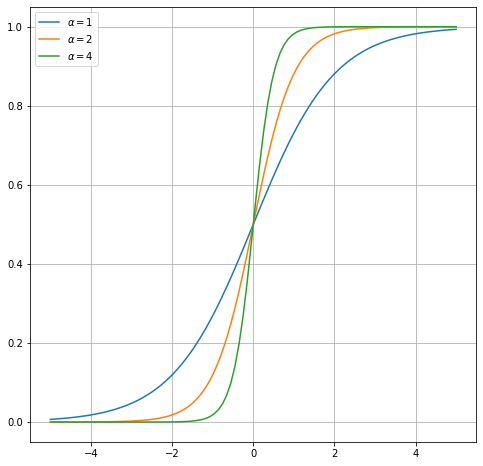

In [263]:
def sigm(x, alpha=1): return 1/(1+np.exp(-alpha * x))

x = np.linspace(-5, 5, 100)

plt.figure(figsize=(8, 8))
plt.plot(x, sigm(x), label=f'$\\alpha = 1$')
plt.plot(x, sigm(x, 2), label=f'$\\alpha = 2$')
plt.plot(x, sigm(x, 4), label=f'$\\alpha = 4$')
plt.legend()
plt.grid()
plt.show()

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [264]:
from numpy import linalg
from copy import deepcopy

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    w = np.zeros(shape=(X.shape[1], 1))
    if (trace): w_l = []

    err_last = cross_entropy_error(X, y, w, alpha)
    for i in range(max_iter):
        delta_w = np.zeros(shape=w.shape)
        
        for j, x in enumerate(X):
            x = x.reshape(1, -1).T
            h = lr_h(x, w)
            delta_w = delta_w - x*(h - y[j])
        
        w[0, 0] = w[0, 0] + eta * delta_w[0, 0]
        w[1:, 0] = w[1:, 0] * (1 - eta * alpha) + eta * delta_w[1:, 0]

        if (trace): w_l.append(deepcopy(w))

        err = cross_entropy_error(X, y, w, alpha)
        
        if (abs(err_last - err) < epsilon):
            if (trace): return w, w_l
            return w
            
        err_last = err
        
    if (trace): return w, w_l
    return w

def cross_entropy_error(X, y, w, alpha=0):
    h = lr_h(X.T, w)
    return 1/len(y) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h), axis=1)[0] # + alpha/2 * linalg.norm(w)

def lr_h(x, w):
    return sigm(w.T.dot(x))   

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [265]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

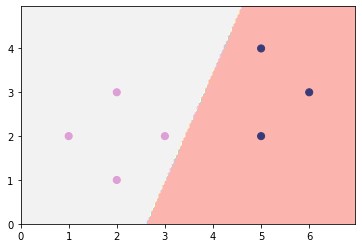

[[ 4.45449454]
 [-1.71089242]
 [ 0.68413507]]
0.13521872720206746


In [266]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

seven_X2 = PolynomialFeatures(degree=1).fit_transform(seven_X)
w = lr_train(seven_X2, seven_y)

def h(x): 
    return sigm(w.T.dot(PolynomialFeatures(degree=1).fit_transform(x).T)) >= 0.5

plot_2d_clf_problem(seven_X, seven_y, h)
plt.show()

print(w)
print(cross_entropy_error(seven_X2, seven_y, w))

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [267]:
from sklearn.metrics import zero_one_loss

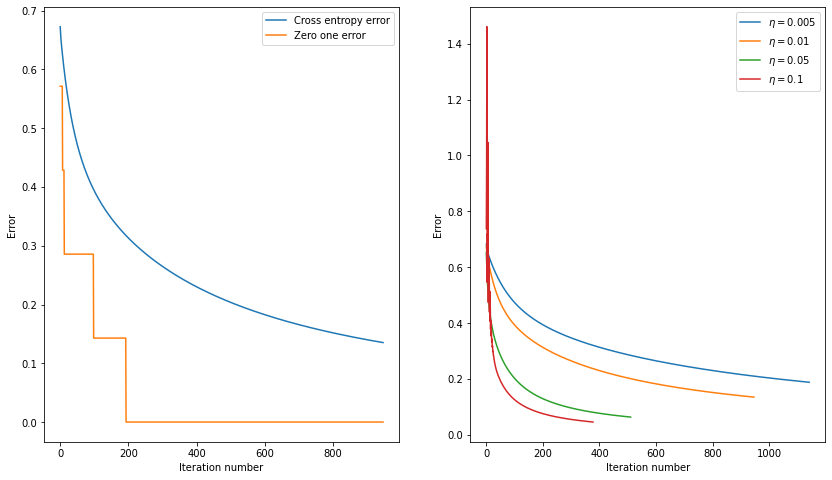

In [268]:
_, w_l = lr_train(seven_X2, seven_y, trace=True)

def h2(x): return sigm(w.T.dot(x)) >= 0.5

d_entropy, d_zero_one = {}, {}

for i, w in enumerate(w_l):
    err_entropy = cross_entropy_error(seven_X2, seven_y, w)
    err_zero_one = zero_one_loss(h2(seven_X2.T)[0], seven_y)

    d_entropy[i] = err_entropy
    d_zero_one[i] = err_zero_one
    
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
axs[0].plot(list(d_entropy.keys()), list(d_entropy.values()), label='Cross entropy error')
axs[0].plot(list(d_zero_one.keys()), list(d_zero_one.values()), label='Zero one error')
axs[0].legend()
axs[0].set_xlabel('Iteration number')
axs[0].set_ylabel('Error')

etas = [0.005, 0.01, 0.05, 0.1]
for eta in etas:
    _, w_l = lr_train(seven_X2, seven_y, eta, trace=True)
    d_entropy = {}

    for i, w in enumerate(w_l):
        err_entropy = cross_entropy_error(seven_X2, seven_y, w)
        d_entropy[i] = err_entropy

    axs[1].plot(list(d_entropy.keys()), list(d_entropy.values()), label=f'$\\eta = {eta}$')
axs[1].legend()
axs[1].set_xlabel('Iteration number')
axs[1].set_ylabel('Error')

plt.show()


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

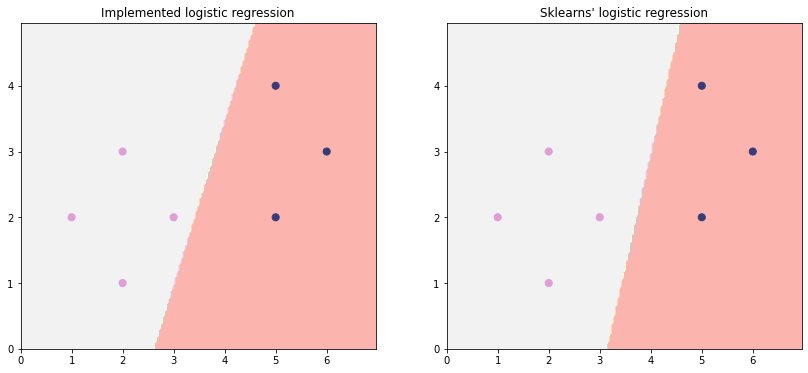

In [269]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000, C=10**6)
lr.fit(seven_X, seven_y)

w, w_l = lr_train(seven_X2, seven_y, trace=True)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plot_2d_clf_problem(seven_X, seven_y, h, axs[0])
axs[0].set_title('Implemented logistic regression')

plot_2d_clf_problem(seven_X, seven_y, lr.predict, axs[1])
axs[1].set_title('Sklearns\' logistic regression')

plt.show()

### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [270]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

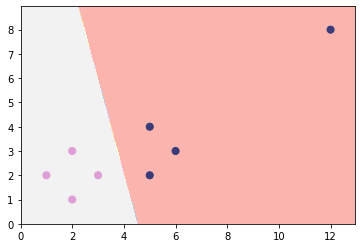

In [271]:
lr = LogisticRegression()
lr.fit(outlier_X, outlier_y)
plot_2d_clf_problem(outlier_X, outlier_y, lr.predict)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

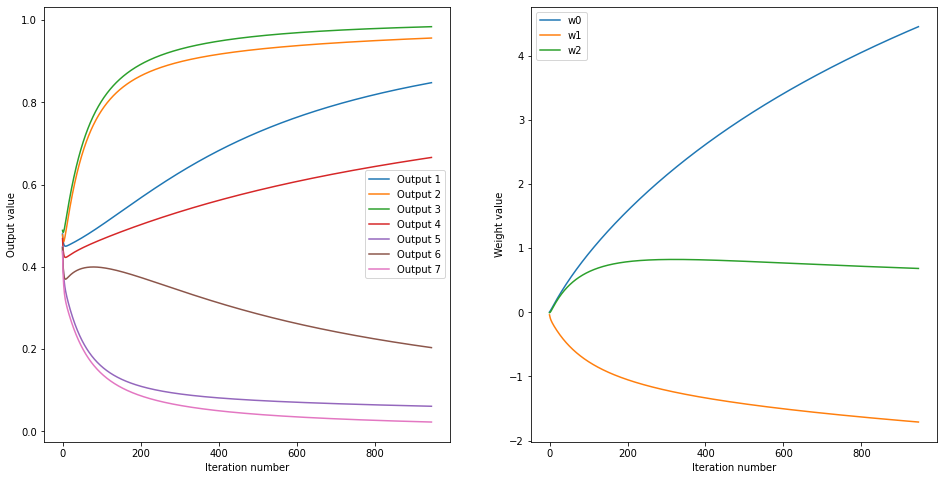

In [272]:
w, w_l = lr_train(seven_X2, seven_y, trace=True)

def h3(x, w): return sigm(w.T.dot(x))

lists = [[], [], []]
l = [[] for i in range(seven_X2.shape[0])]

for i, w_i in enumerate(w_l):
    y_hat = h3(seven_X2.T, w_i)
    for j, y_j in enumerate(y_hat[0]):
        l[j].append(y_j)
    
    for j, _ in enumerate(lists):
        lists[j].append(w_i[j])

labels = [f'Output {i + 1}' for i in range(seven_X2.shape[0])]
w_labels = ['w0', 'w1', 'w2']

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
for i, l_i in enumerate(l):
    axs[0].plot(l_i, label=labels[i])
axs[0].set_xlabel('Iteration number')
axs[0].set_ylabel('Output value')
axs[0].legend()

for i, l_i in enumerate(lists):
    axs[1].plot(l_i, label=w_labels[i])
axs[1].set_xlabel('Iteration number')
axs[1].set_ylabel('Weight value')
axs[1].legend()

plt.show()

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [273]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

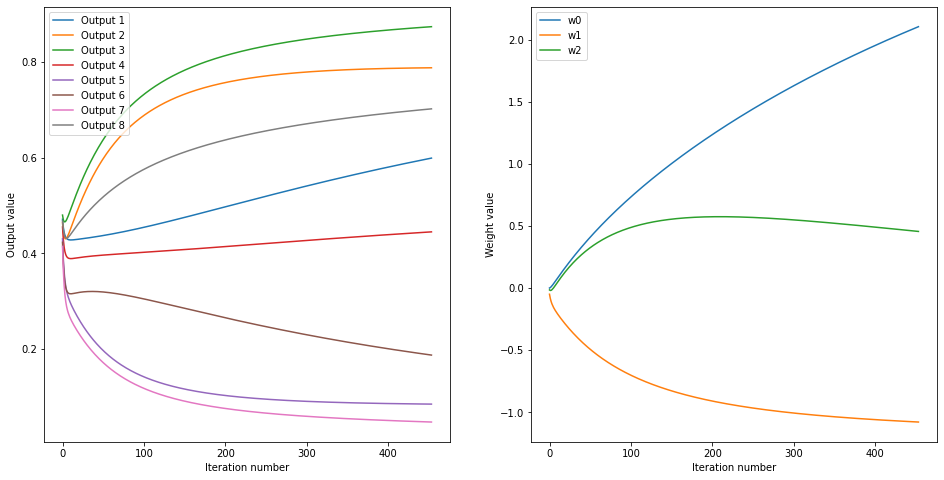

In [274]:
unsep_X2 = PolynomialFeatures(degree=1).fit_transform(unsep_X)

w, w_l = lr_train(unsep_X2, unsep_y, trace=True)

lists = [[], [], []]
l = [[] for i in range(unsep_X2.shape[0])]

for i, w_i in enumerate(w_l):
    y_hat = h3(unsep_X2.T, w_i)
    for j, y_j in enumerate(y_hat[0]):
        l[j].append(y_j)
    
    for j, _ in enumerate(lists):
        lists[j].append(w_i[j])

labels = [f'Output {i + 1}' for i in range(unsep_X2.shape[0])]
w_labels = ['w0', 'w1', 'w2']

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
for i, l_i in enumerate(l):
    axs[0].plot(l_i, label=labels[i])
axs[0].set_xlabel('Iteration number')
axs[0].set_ylabel('Output value')
axs[0].legend()

for i, l_i in enumerate(lists):
    axs[1].plot(l_i, label=w_labels[i])
axs[1].set_xlabel('Iteration number')
axs[1].set_ylabel('Weight value')
axs[1].legend()

plt.show()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [275]:
from numpy.linalg import norm

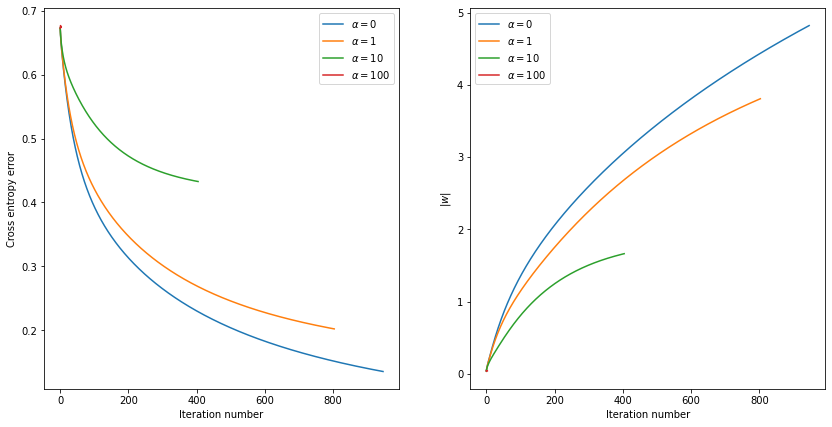

In [276]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

alphas = [0, 1, 10, 100]
for i, alpha in enumerate(alphas):
    X = PolynomialFeatures(degree=1).fit_transform(seven_X)
    w_last, w_l = lr_train(X, seven_y, alpha=alpha, trace=True)

    d_err = {}
    for j, w in enumerate(w_l):
        d_err[j] = cross_entropy_error(X, seven_y, w, alpha=alpha)
    
    axs[0].plot(
        list(d_err.keys()),
        list(d_err.values()),
        label=f'$\\alpha = {alpha}$'
    )

    axs[1].plot(
        list(range(len(w_l))), 
        [norm(w_i) for w_i in w_l],
        label=f'$\\alpha = {alpha}$'
    )

axs[0].legend()
axs[0].set_xlabel('Iteration number')
axs[0].set_ylabel('Cross entropy error')

axs[1].legend()
axs[1].set_xlabel('Iteration number')
axs[1].set_ylabel('$|w|$')

plt.show()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

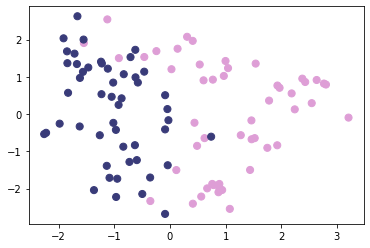

In [277]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=2,   
    n_classes=2
)
plot_2d_clf_problem(X, y)

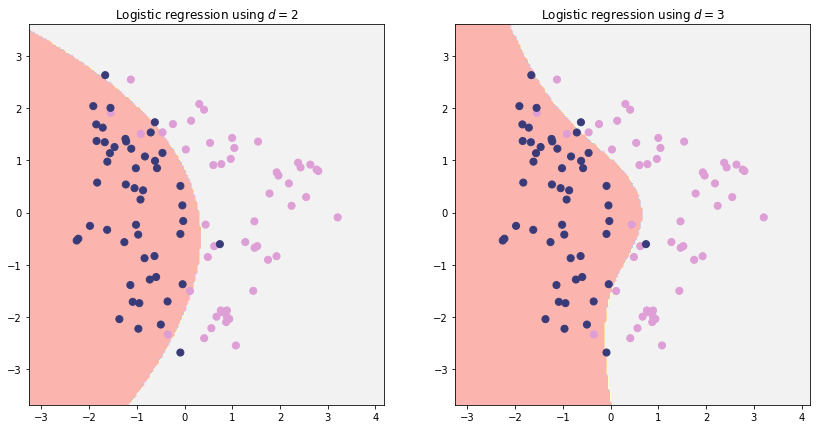

In [278]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

pf = PolynomialFeatures(degree=2).fit(X)
model = LogisticRegression()
model.fit(pf.transform(X), y)
plot_2d_clf_problem(X, y, lambda x: model.predict(pf.transform(x)), axs[0])
axs[0].set_title('Logistic regression using $d = 2$')

pf = PolynomialFeatures(degree=3).fit(X)
model = LogisticRegression()
model.fit(pf.transform(X), y)
plot_2d_clf_problem(X, y, lambda x: model.predict(pf.transform(x)), axs[1])
axs[1].set_title('Logistic regression using $d = 3$')

plt.show()

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?